## 1. Define Classes

In [11]:
!pip install pip chart_studio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import chart_studio as py
import cufflinks as cf
cf.go_offline(connected=True)
from scipy import optimize 
from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

try:
  import pandas_datareader.data as web
except:
  !pip install pip pandas-datareader
  import pandas_datareader.data as web

     |████████████████████████████████| 71kB 5.3MB/s 


In [12]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.ratio = 0
    self.price = None
    self.change = None

  def put_price_change(self):
    self.price = self.data['Adj Close']
    self.change = self.price.pct_change().to_list()

  def get_date(self):
    return self.date

  def get_change(self):
    return self.change

  def get_name(self):
    return self.name

In [13]:
class GMV_Asset(Asset):
    def __init__(self, ticker_list, start, end):
        self.ticker_list = ticker_list
        self.start = start
        self.end = end
        self.df = pd.DataFrame(columns=self.ticker_list)
        self.asset_list = []
        
    def create_df(self):
        for stock in self.ticker_list:
            asset = Asset(stock, stock, self.start, self.end)
            self.asset_list.append(asset)
            self.df[stock] = asset.data["Adj Close"]

            if stock == self.ticker_list[0]:
                self.df['date'] = asset.data.index
                self.df.set_index('date', inplace=True)
            
    def get_returns(self):
        return self.df.pct_change()

    def get_mean_returns(self):
        return self.get_returns().mean()
    
    def get_cov_matrix(self):
        return self.get_returns().cov()

In [21]:
class AWF_Asset(Asset):
    def __init__(self, equity_ticker_list, inl_ticker_list, corp_ticker_list,
                 bond_ticker_list, emd_ticker_list, comm_ticker_list, start, end):
        self.start = start
        self.end = end
        self.result = []
        self.asset_list = []
        self.total_ticker_dict = {
            "equity_ticker_list" : equity_ticker_list,
            "inl_ticker_list" : inl_ticker_list,
            "corp_ticker_list" : corp_ticker_list,
            "bond_ticker_list" : bond_ticker_list,
            "emd_ticker_list" : emd_ticker_list,
            "comm_ticker_list" : comm_ticker_list
        }
        self.result_dict = {
            "equity" : [],
            "inl" : [],
            "corp" : [],
            "bond" : [],
            "emd" : [],
            "comm" : []
        }
        
    def create_dict(self):
        for t_key in self.total_ticker_dict:
            for stock in self.total_ticker_dict[t_key]:
                asset = Asset(stock, stock, self.start, self.end)
                self.asset_list.append(asset)
                value = asset.data["Adj Close"].pct_change().dropna()
                
                key = t_key.split("_")[0]
                self.result_dict[key].append(value)
                
    def calculate_value(self):
        for label in self.result_dict:
            value = self.result_dict[label][0]
            
            for i in range(len(self.result_dict[label]) - 1):
                value += self.result_dict[label][i]
            
            avg = value / len(self.result_dict[label])
            self.result.append(avg)
        return self.result
    
    def get_value(self):
        self.create_dict()
        return self.calculate_value(), self.total_ticker_dict

In [25]:
class Portfolio():
    def __init__(self, name, lb_assets, assets, ratios, initial_balance, rebalancing_interval=0, awf_lb_ret={}, awf_ticker={}):
        self.name = name
        
        # list of class asset elements
        self.assets = assets
        self.lb_assets = lb_assets
        self.awf_ticker = awf_ticker

        # Assert all the dates for assets are equal and set portfolio start, end dates
        dates = [each.get_date() for each in self.assets]
        lendates = [len(each) for each in dates]
        assert len(set(lendates)) == 1
        self.date = dates[0]

        self.ratios = [each / sum(ratios) for each in ratios]

        for i in range(len(self.assets)):
            self.assets[i].put_price_change()

        self.initial_balance = initial_balance    
        self.rebalancing_interval = rebalancing_interval

        self.gmv_weights = []         # weights for gmv
        self.awf_weights = []
        self.backtest_df = None
        self.backtest_result_df = None
        self.summary = None

    def backtest(self):
        # 첫 거래일
        balances = []
        
        asset_df = pd.DataFrame()
        lb_asset_df = pd.DataFrame()
        
        # 자산 수익률 계산
        for i in range(len(self.assets)):
            asset_df[i] = self.assets[i].data["Adj Close"]
        
        # Look Back 데이터 자산 수익률 계산
        if self.name == "GMV" or self.name == "All Weather":
            for i in range(len(self.lb_assets)):
                lb_asset_df[i] = self.lb_assets[i].data["Adj Close"]
        
        # 자산별 초기 balance ex[300, 300, 400]
        for i in range(len(self.assets)):
            balance = [self.initial_balance * self.ratios[i]]
            balances.append(balance)
        
        total_balance = [self.initial_balance]  # 초기 밸런스 값 ex)1000
        next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]  # 다음 리밸런싱 기간 ex)2016-04-04
        
        # 이후 거래일
        for i in range(1, len(self.date)):
            total_balance_tmp = 0
        
            #리밸런싱 하는 날
            if self.date[i] >= next_rebalancing[i-1]:
                
                # 다음 리밸런싱 날짜 업데이트
                next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
                
                # GMV 포트폴리오 dynamic weight 분배
                if self.name == "GMV":
                    GMV = GMVPortfolio(lb_asset_df[:i].pct_change().mean(), lb_asset_df[:i].pct_change().cov(), num_portfolios=25000, risk_free_rate=0.0178)
                    self.gmv_weights = [round(i, 2) for i in GMV.min_variance().x]
                    weight = self.gmv_weights
                    
                elif self.name == "All Weather":
                    for w in range(len(awf_lb_ret)):
                        awf_lb_ret[w] = awf_lb_ret[w][:i]
                    AWF = AllWeatherPortfolio(awf_lb_ret, self.awf_ticker)
                    self.awf_weights = AWF.awf()
                    weight = self.awf_weights
                else:
                    weight = self.ratios
                    
                for j in range(len(self.assets)):
                    # i시점의 j자산에 대한 밸런스 계산
                    balance = total_balance[i-1] * weight[j] * (1 + self.assets[j].get_change()[i])
                    # 자산별 밸런스 리스트에 추가
                    balances[j].append(balance)
                    # i 시점의 전체 밸런스 계산
                    total_balance_tmp += balances[j][i]
            
            # 리밸런싱 하지 않는 날
            else:
                # 이전 리밸런싱 날짜랑 동일하게
                next_rebalancing.append(next_rebalancing[i-1])
                # Asset 번호
                for j in range(len(self.assets)):
                    try:
                        balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_change()[i]))
                    except:
                        balances[j].append(balances[j][i-1])
                    total_balance_tmp += balances[j][i]
            
            # 밸런스 업데이트
            total_balance.append(total_balance_tmp)

            print("jw ", total_balance)

        df = pd.DataFrame()
        df['Date'] = self.date
        df.set_index('Date', inplace=True)
        df['Total'] = total_balance

        for i in range(len(self.assets)):
            df[self.assets[i].get_name()] = balances[i]
        
        print('Portfolio Backtest Complete')
        self.backtest_df = df
        
        # 밸런스 DataFrame 반환
        return df

    def balance_result(self, balance):
        change = [0]
        cum_return = [0]
        prev_high = [0]
        prev_high_tmp = 0
        drawdown = [0]
        mdd = [0]
        mdd_tmp = 0
        CAGR = [0]
        stdev = [0]
        sharpe = [0]

        time_period = (self.date[-1] - self.date[0]).days / 365

        for i in range(1, len(self.date)):
            change.append((balance[i] / balance[i-1] - 1) * 100)
            cum_return.append((balance[i] / balance[0] - 1) * 100)

            if prev_high_tmp < cum_return[i]:
                prev_high_tmp = cum_return[i]
            else:
                prev_high_tmp = prev_high_tmp

            prev_high.append(prev_high_tmp)

            CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)
            drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

            if mdd_tmp > drawdown[i]:
                mdd_tmp = drawdown[i]
            else:
                mdd_tmp = mdd_tmp

            mdd.append(mdd_tmp)
            stdev.append(np.std(change))
            
            if stdev[i] != 0:
                sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
            else:
                sharpe.append(0)
                        
        return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

    def backtest_result(self):
        df = pd.DataFrame()
        df['Date'] = self.date
        df.set_index('Date', inplace=True)
        label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD', 'St. Dev', 'Sharpe']


        result = dict()

        # 각 자산 i에 대한 밸런스결과 계산
        result['Total'] = self.balance_result(self.backtest_df['Total'].to_list())
        df['Total Balance'] = self.backtest_df['Total'].to_list()
        print('Total Balance Complete')

        # 각 자산별 [Change, ..., Sharpe] 계산
        for j in range(len(label)):
            df[f'Total {label[j]}'] = result['Total'][j]

        self.backtest_result_df = df
        
        return df
    
    def periodic_result(self, mode):
        df = pd.DataFrame()

        label = 'Total'
        return_points = []
        returns = []
        start_balance = []
        end_balance = []
        start = self.backtest_df[label].to_list()[0]

        if mode == 'annual':
            for i in range(1, len(self.date)):
                if self.date[i].year != self.date[i-1].year:
                    return_points.append(self.date[i-1].year)
                    returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
                    start_balance.append(start)
                    end_balance.append(self.backtest_df[label].to_list()[i-1])
                    start = self.backtest_df[label].to_list()[i]
                elif self.date[i] == self.date[-1]: # 마지막 거래일
                    return_points.append(self.date[i].year)
                    returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
                    start_balance.append(start)
                    end_balance.append(self.backtest_df[label].to_list()[i-1])
            df[f'{label} {mode.capitalize()} Return'] = returns

        elif mode == 'monthly':
            for i in range(1, len(self.date)):
                if self.date[i].month != self.date[i-1].month:
                    return_points.append(self.date[i-1].strftime('%Y-%m'))
                    returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
                    start_balance.append(start)
                    end_balance.append(self.backtest_df[label].to_list()[i-1])
                    start = self.backtest_df[label].to_list()[i]
                elif self.date[i] == self.date[-1]: # 마지막 거래일
                    return_points.append(self.date[i].strftime('%Y-%m'))
                    returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
                    start_balance.append(start)
                    end_balance.append(self.backtest_df[label].to_list()[i-1])
            df[f'{label} {mode.capitalize()} Return'] = returns

        df[f'Return {mode.capitalize()}'] = return_points
        df.set_index(f'Return {mode.capitalize()}', inplace=True)

        print(f'{mode.capitalize()} Result Complete')

        return df

    def get_name(self):
        return self.name

    def get_date(self):
        return self.date

    def get_backtest_result(self):
        return self.backtest_result_df

    def get_summary(self):
        # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']
        
        detail = ''
        for i in range(len(self.assets)):
            name = self.assets[i].get_name()
            if self.name == "GMV":
                percentage = int(self.gmv_weights[i] * 100)
            else:
                percentage = int(self.ratios[i] * 100)

            detail += f'{name} ({percentage}%)'

        self.summary = [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1],
                                        str(round(self.backtest_result_df['Total CAGR'][-1], 2))+'%', str(round(self.backtest_result_df['Total MDD'][-1], 2))+'%',
                                        round(self.backtest_result_df['Total St. Dev'][-1], 2), round(self.backtest_result_df['Total Sharpe'][-1], 2)]
        
        return self.summary

In [16]:
#class portfolio takes matrix of returns for every stock, and array of their weights
class GMVPortfolio:
    def __init__(self, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
        self.mean_returns = mean_returns
        self.cov_matrix = cov_matrix
        self.num_portfolios = num_portfolios
        self.risk_free_rate = risk_free_rate

    def neg_sharpe_ratio(self, weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = self.portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        return -(p_ret - risk_free_rate) / p_var

    def max_sharpe_ratio(self):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix, self.risk_free_rate)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))
        result = optimize.minimize(self.neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                            method='SLSQP', bounds=bounds, constraints=constraints)
        return result
    
    def portfolio_volatility(self, weights, mean_returns, cov_matrix):
        return self.portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

    def min_variance(self):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))

        result = optimize.minimize(self.portfolio_volatility, num_assets*[1./num_assets,], args=args,
                            method='SLSQP', bounds=bounds, constraints=constraints)

        return result

    def portfolio_return(self, weights):
        return self.portfolio_annualised_performance(weights, self.mean_returns, self.cov_matrix)[1]
    
    def efficient_return(self, target):
        num_assets = len(self.mean_returns)
        args = (self.mean_returns, self.cov_matrix)

        constraints = ({'type': 'eq', 'fun': lambda x: self.portfolio_return(x) - target},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for asset in range(num_assets))
        result = optimize.minimize(self.portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
        return result


    def efficient_frontier(self, returns_range):
        efficients = []
        for ret in returns_range:
            efficients.append(self.efficient_return(ret))
        return efficients
    
    def portfolio_annualised_performance(self, weights, mean_returns, cov_matrix):
        returns = np.sum(self.mean_returns*weights ) *252
        std = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights))) * np.sqrt(252)
        return std, returns
    
    def random_portfolios(self):
        results = np.zeros((3, self.num_portfolios))
        weights_record = []
        for i in range(self.num_portfolios):
            weights = np.random.random(self.mean_returns.shape[0])
            weights /= np.sum(weights)
            weights_record.append(weights)
            portfolio_std_dev, portfolio_return = self.portfolio_annualised_performance(weights, self.mean_returns, self.cov_matrix)
            results[0,i] = portfolio_std_dev
            results[1,i] = portfolio_return
            results[2,i] = (portfolio_return - self.risk_free_rate) / portfolio_std_dev
        return results, weights_record       
        
    def display_ef_with_selected_and_random(self, returns, cols):
        results, _ = self.random_portfolios()
        
        max_sharpe = self.max_sharpe_ratio()
        sdp, rp = self.portfolio_annualised_performance(max_sharpe['x'], self.mean_returns, self.cov_matrix)
        max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=cols,columns=['allocation'])
        max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
        max_sharpe_allocation = max_sharpe_allocation.T

        min_vol = self.min_variance()
        sdp_min, rp_min = self.portfolio_annualised_performance(min_vol['x'], self.mean_returns, self.cov_matrix)
        min_vol_allocation = pd.DataFrame(min_vol.x,index=cols,columns=['allocation'])
        min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
        min_vol_allocation = min_vol_allocation.T

        an_vol = np.std(returns) * np.sqrt(252)
        an_rt = self.mean_returns * 252

        print("-"*80)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        print("Annualised Return:", round(rp,2))
        print("Annualised Volatility:", round(sdp,2))
        print("\n")
        print(max_sharpe_allocation)
        print("-"*80)
        print("Minimum Volatility Portfolio Allocation\n")
        print("Annualised Return:", round(rp_min,2))
        print("Annualised Volatility:", round(sdp_min,2))
        print("\n")
        print(min_vol_allocation)
        print("-"*80)
        print("Individual Stock Returns and Volatility\n")
        for i, txt in enumerate(cols):
            print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
        print("-"*80)

        fig, ax = plt.subplots(figsize=(10, 7))
        ax.scatter(an_vol,an_rt,marker='o',s=200)
        ax.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)

        for i, txt in enumerate(cols):
            ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
        ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
        ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

        target = np.linspace(rp_min, 0.34, 50)
        efficient_portfolios = self.efficient_frontier(target)
        ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
        ax.set_title('Portfolio Optimization with Individual Stocks')
        ax.set_xlabel('annualised volatility')
        ax.set_ylabel('annualised returns')
        ax.legend(labelspacing=0.8)        

In [17]:
class AllWeatherPortfolio(Asset):
    
    def __init__(self, dictionary, ticker):
        self.result = dictionary
        self.total_ticker_dict = ticker
   
    def merge(self):
        port = pd.concat(self.result, axis =1 )
        port.columns = ['equity', 'infl', 'corp', 'bond', 'emd', 'comm']
        asset_num = len(port.columns)

        port_gr_r = (self.result[0] + self.result[2] + self.result[4] + self.result[5])/4
        port_gr_f = (self.result[1] + self.result[4] + self.result[5])/3
        port_inf_r = (self.result[1] + self.result[3])/2
        port_inf_f = (self.result[0] + self.result[3])/2

        portfolio = pd.concat([port_gr_r, port_gr_f, port_inf_r, port_inf_f], axis =1 )
        portfolio.columns = ['gr_r', 'gr_f', 'inf_r', 'inf_f' ]
        self.covmat = portfolio.cov()

    def RiskParity_objective(self, x) :
#         print("EUM1")
        variance = x.T @ self.covmat @ x
#         print("EUM2", variance)
        sigma = variance ** 0.5
#         print("EUM3", sigma)
        mrc = 1/sigma * (self.covmat @ x)
#         print("EUM4", mrc)
        rc = x * mrc  
#         print("EUM5", rc)
        rc = rc/rc.sum() 
#         print("EUM6", rc) 
        a = pd.DataFrame(index = range(len(x)), columns = range(len(x)))
#         print("EUM7", a)
        for i in range (0, len(x)):
            for j in range(0, len(x)):
              a[i][j]  = rc[i] - rc[j]
#         print("EUM8")
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(a)))
#         print("EUM9", sum_risk_diffs_squared)
        return sum_risk_diffs_squared


    def weight_sum_constraint(self, x):
        result = x.sum() - 1.0
        return result

    def weight_longonly(self, x):
        return x

    def RiskParity(self):
        x0 = np.repeat(1 / self.covmat.shape[1], self.covmat.shape[1])
        con1 = {'type' : 'eq', 'fun' : self.weight_sum_constraint}
        con2 = {'type': 'ineq', 'fun' : self.weight_longonly}  
        constraint =  ([con1, con2])
        options = {'ftol' : 1e-20}
        result = optimize.minimize(fun = self.RiskParity_objective,
                    x0 = x0,
                    method = 'SLSQP',
                    constraints = constraint,
                    options = options)
        return result.x


    def weight(self, wt_erc):
        weight = [] 
        
        for label in self.total_ticker_dict:
            if label == "equity_ticker_list":
                length = len(self.total_ticker_dict[label])
                for i in range(length):
                    weight.append(wt_erc[0]/(4*length) + wt_erc[3]/(2*length))              
            elif label == "inl_ticker_list":
                weight.append(wt_erc[1]/3 +  wt_erc[2]/2)            
            elif label == "corp_ticker_list":
                weight.append(wt_erc[0]/4)
            elif label == "bond_ticker_list":
                length = len(self.total_ticker_dict[label])
                for i in range(length):
                    weight.append(wt_erc[2]/(2*length) + wt_erc[3]/(2*length))               
            elif label == "emd_ticker_list":
                length = len(self.total_ticker_dict[label])
                for i in range(length):
                    weight.append(wt_erc[0]/(4*length) + wt_erc[1]/(3*length))
            elif label == "comm_ticker_list":
                for i in range(length):
                    weight.append(wt_erc[0]/(4*length) + wt_erc[1]/(3*length))

        return weight

    def awf(self):
        self.merge()
        wt_erc = self.RiskParity()
        x = self.weight(wt_erc)

        return x


In [18]:
class Visualize():
    def __init__(self, portfolios):
        self.portfolios = portfolios

        # Assert all the dates for assets are equal and set portfolio start, end dates
        dates = [each.get_date() for each in self.portfolios]
        lendates = [len(each) for each in dates]
        assert len(set(lendates)) == 1
        self.date = dates[0]

    # def line_plot(self, result=drawdown, title, return_type=linear):
    def line_plot(self, result, title, return_type):
        data_list = []
        colm_list = []
        for i in range(len(self.portfolios)):
            data_list.append(self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'])
            colm_list.append(self.portfolios[i].get_name())
        plot_df = pd.DataFrame(data_list).T
        plot_df.columns = colm_list
        plot_df.iplot(kind='line')
    
    
    
    def bar_plot(self, title, period):
        data_list = []
        colm_list = []
        for i in range(len(self.portfolios)):
          if period == 'annual':
            data_list.append(self.portfolios[i].periodic_result('annual').loc[:, 'Total Annual Return'])
            colm_list.append(self.portfolios[i].get_name())
          elif period == 'monthly':
            data_list.append(self.portfolios[i].periodic_result('monthly').loc[:, 'Total Monthly Return'])
            colm_list.append(self.portfolios[i].get_name())

        plot_df = pd.DataFrame(data_list).T
        plot_df.columns = colm_list
        plot_df.iplot(kind='bar', barmode='stack')

In [19]:
start_date = "2016-04-02"
end_date = "2020-10-31"

look_back_period = 3
lb_start_list = list(map(int, start_date.split("-")))
lb_start_temp = datetime(lb_start_list[0], lb_start_list[1], lb_start_list[2]) + relativedelta(months=-look_back_period)
lb_start_date = f"{lb_start_temp.year}-{lb_start_temp.month}-{lb_start_temp.day}"
lb_end_list = list(map(int, start_date.split("-")))
lb_end_temp = datetime(lb_end_list[0], lb_end_list[1], lb_end_list[2]) + relativedelta(days=-1)
lb_end_date = f"{lb_end_temp.year}-{lb_end_temp.month}-{lb_end_temp.day}"

## 2. GMV Portfolio

### 1) GMV - Calculation

In [ ]:
gmv_portfolio_list = ['AMZN', 'AAPL', 'GOOGL', 'SBUX', 'SO', 'INTC', 'CSCO', 'MET']

# calculate inital weights
gmv_lb_asset = GMV_Asset(gmv_portfolio_list, lb_start_date, lb_end_date)
gmv_lb_asset.create_df()
GMV = GMVPortfolio(gmv_lb_asset.get_mean_returns(), gmv_lb_asset.get_cov_matrix(), num_portfolios=25000, risk_free_rate=0.0178)
gmv_initial_weights = [round(i, 2)for i in GMV.min_variance().x]

# get asset data
gmv_asset = GMV_Asset(gmv_portfolio_list, start_date, end_date)
gmv_asset.create_df()

gmv_portfolio = Portfolio('GMV', gmv_lb_asset.asset_list, gmv_asset.asset_list, gmv_initial_weights, 1000, 3)
gmv_backtest_df = gmv_portfolio.backtest()
backtest_result_df = gmv_portfolio.backtest_result()
gmv_annual_return_df = gmv_portfolio.periodic_result('annual')
gmv_monthly_return_df = gmv_portfolio.periodic_result('monthly')
gmv_portfolio.get_summary()

Portfolio Backtest Complete
Total Balance Complete
Annual Result Complete
Monthly Result Complete


['AMZN (1%)AAPL (5%)GOOGL (0%)SBUX (1%)SO (74%)INTC (0%)CSCO (12%)MET (7%)',
 1000.0,
 1526.2845282714277,
 '9.66%',
 '-37.33%',
 1.4,
 0.52]

### 2) GMV - Efficient Frontier

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.44
Annualised Volatility: 0.13


            AMZN  AAPL  GOOGL  SBUX     SO  INTC   CSCO  MET
allocation   0.0  0.69    0.0   0.0  83.23   0.0  16.07  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.38
Annualised Volatility: 0.13


            AMZN  AAPL  GOOGL  SBUX    SO  INTC   CSCO   MET
allocation  1.23  4.69    0.0  1.19  74.0   0.0  11.71  7.18
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AMZN : annuaised return -0.17 , annualised volatility: 0.3
AAPL : annuaised return 0.25 , annualised volatility: 0.3
GOOGL : annuaised return 0.09 , annualised volatility: 0.26
SBUX : annuaised return 0.24 , annualised volatility: 0.27
SO : annuaised return 0.45 , annualised vola

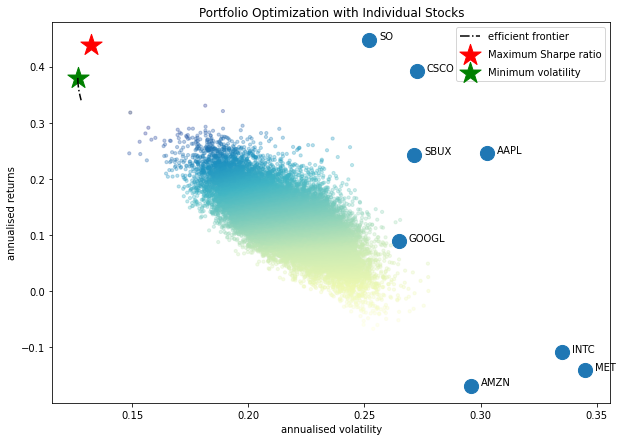

In [ ]:
GMV.display_ef_with_selected_and_random(gmv_asset.get_returns(), gmv_portfolio_list)

## 3. 60/40 Portfolio

In [27]:
asset1 = Asset('^IXIC', 'Asset 1', start_date, end_date)
asset2 = Asset('VUSTX', 'Asset 2', start_date, end_date)

sixty_forty_portfolio = Portfolio('60/40', [], [asset1, asset2], [6, 4], 1000, 3)
sixty_forty_backtest_df = sixty_forty_portfolio.backtest()
sixty_forty_backtest_result_df = sixty_forty_portfolio.backtest_result()
sixty_forty_annual_return_df = sixty_forty_portfolio.periodic_result('annual')
sixty_forty_monthly_return_df = sixty_forty_portfolio.periodic_result('monthly')
sixty_forty_summary = sixty_forty_portfolio.get_summary()
sixty_forty_summary

Output hidden; open in https://colab.research.google.com to view.

## 4. All Weather Portfolio

In [26]:
equity = ['VTI', 'WFSPX']
infl = ['TIP']
corp = ['LQD']
bond = ['TLT']
emd = ['EMB', 'EWZ']
comm = ['IAU', 'DBA']

# calculate intial weight
awf_lb_asset = AWF_Asset(equity, infl, corp, bond, emd, comm, lb_start_date, lb_end_date)
awf_lb_ret, awf_lb_ticker = awf_lb_asset.get_value()
awf_initial_weight = AllWeatherPortfolio(awf_lb_ret, awf_lb_ticker).awf()

# get asset data
awf_asset = AWF_Asset(equity, infl, corp, bond, emd, comm, start_date, end_date)
awf_asset.create_dict()
awf_portfolio = Portfolio('All Weather', awf_lb_asset.asset_list, awf_asset.asset_list, awf_initial_weight, 1000, 3, 
                          awf_lb_ret=awf_lb_asset.result_dict, awf_ticker=awf_asset.total_ticker_dict)
awf_backtest_df = awf_portfolio.backtest()
awf_backtest_result_df = awf_portfolio.backtest_result()
awf_annual_return_df = awf_portfolio.periodic_result('annual')
awf_monthly_return_df = awf_portfolio.periodic_result('monthly')
awf_summary = awf_portfolio.get_summary()
awf_summary

Output hidden; open in https://colab.research.google.com to view.

## 5. Result Visualization

In [ ]:
aw_64 = Visualize([gmv_portfolio, sixty_forty_portfolio, awf_portfolio])
# aw_64 = Visualize([sixty_forty_portfolio, awf_portfolio])

In [ ]:
aw_64.line_plot('Drawdown', 'GMV VS 60/40 VS All Weather Drawdown', 'linear')

In [ ]:
aw_64.bar_plot('GMV VS 60/40 VS All Weather Monthly Return', 'monthly')

Monthly Result Complete
Monthly Result Complete
Monthly Result Complete
